In [3]:
import copy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from typing import Callable
import torch
import torch.nn as nn
import torch.nn.functional as F
import MyNeuralNetwork_New
import random


### PyTorch network class for comparison with our network

In [4]:
# pyTorch neural network class

class myPytorchNetwork(nn.Module):
    def __init__(self, layers, activation):
        super(myPytorchNetwork, self).__init__()
        self.activation = activation
        self.fc_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])

    def forward(self, x):
        x = torch.flatten(x, 1)

        # TODO: I'm using relus everywhere for now, we need to change it to be adjustable
        for layer in self.fc_layers[:-1]:
            if self.activation == 'linear':
                x = layer(x)
            elif self.activation == 'relu':
                x = F.relu(layer(x))
            elif self.activation == 'sigmoid':
                x = torch.sigmoid(layer(x))
            elif self.activation == 'tanh':
                x = torch.tanh(layer(x))
            else:
                raise ValueError(f"Activation funtion {self.activation} is invalid")


        # No need for activation in the last layer
        return self.fc_layers[-1](x)


def train_torch_network(network: myPytorchNetwork, dataset, max_epochs, batch_size, train_ratio=0.8,
                        learning_rate=0.001, momentum=0.9, silent=False):
    loss_fn = torch.nn.MSELoss()
    # TODO: think of making the learning rate adaptive here, e.g. by using pytorch LR scheduler
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    split_index = int(dataset.shape[0] * train_ratio)
    train, validation = dataset[:split_index, :], torch.from_numpy(dataset[split_index:, :])

    best_validation_loss = float("inf")

    for epoch in range(max_epochs):
        np.random.shuffle(train)
        torch_train = torch.from_numpy(train)
        batch_start_idx = 0

        batches_loss = []
        # This way we skip last samples if there are less than batch_size of them
        while batch_start_idx + batch_size <= torch_train.shape[0]:
            optimizer.zero_grad()
            outputs = network(torch_train[batch_start_idx:batch_start_idx + batch_size, :-1])
            loss = loss_fn(torch.flatten(outputs), torch_train[batch_start_idx:batch_start_idx + batch_size, -1])
            batches_loss.append(loss.item())

            loss.backward()

            optimizer.step()
            batch_start_idx += batch_size

        # Now, check the loss on validation dataset
        validation_output = torch.flatten(network(validation[:, :-1]))
        validation_loss = loss_fn(validation_output, validation[:, -1])

        best_validation_loss = validation_loss

        if not silent:
            print(
                f"Epoch: {epoch}. \nLoss on training: {np.mean(batches_loss)} \nLoss on validation: {validation_loss} \n##########")


### Helper functions to run each model multiple times and gathering statistics

In [72]:
def run_my_neural_network(network_parameters, train_dataset, test_inputs) -> np.array:
    """
    Train our neural network and predict data from test_inputs
    """
    np.random.seed(40)
    random.seed(40)
    network = MyNeuralNetwork_New.MyNeuralNetwork(*network_parameters)
    network.fit(train_dataset[:, :-1], train_dataset[:, [-1]], batch_size=10)
    prediction = network.predict(test_inputs)
    return prediction



def run_linear_regression(train_dataset, test_inputs) -> np.array:
    """
    Train a linear regression on train_inputs, and predict data for test_inputs
    """
    reg = LinearRegression().fit(train_dataset[:, :-1], train_dataset[:, -1])
    prediction = reg.predict(test_inputs)
    return prediction


def run_pytorch_network(network_parameters,  train_dataset, test_inputs) -> np.array:
    """
    Train a pytorch network and predict outputs for test_inputs
    """
    torch.manual_seed(0)
    random.seed(42)
    np.random.seed(42)
    network = myPytorchNetwork(*network_parameters)
    train_torch_network(network, train_dataset, 150, 10, learning_rate=0.001, silent=True, momentum=0.9, train_ratio=0.98)
    prediction = network(torch.from_numpy(test_inputs)).detach().numpy().flatten()
    return prediction


def measure_model_error_multiple_times(model: Callable, dataset_orig: np.array, train_ratio=0.85, num_runs=5, silent=False):
    """
    :param model: a callable that accepts train dataset, test inputs, and produces the prediction for test inputs
    :param dataset_orig: dataset to train on of shape (n_samples, n_features), where the last column is the value to be predicted
    :param train_ratio: how much data to put into the training dataset
    :param num_runs: number of runs with reshuffled dataset
    :param silent: if true, not print any output
    :return: mean MSE through all the runs
    """
    split_index = int(dataset_orig.shape[0] * train_ratio)
    best_mape = 0
    best_mse = float("inf")
    for _ in range(num_runs):
        dataset = dataset_orig.copy()
        # np.random.shuffle(dataset)
        train = dataset[:split_index, :]
        test = dataset[split_index:, :]

        prediction = model(train, test[:, :-1]).flatten()
        expected = test[:, -1].flatten()
        mse = np.mean((prediction - expected) ** 2)

        # Some hard coded descaling for different datasets. Could be made configurable, but was needed only once
        # expected_desc = (expected - 0.1) / 0.8 * (7261.37 - 1675.16) + 1675.16
        # prediction_desc = (prediction - 0.1) / 0.8 * (7261.37 - 1675.16) + 1675.16
        #
        # expected_desc = (expected - 0.1) / 0.8 * (16.080230- (-0.791114)) + (-0.791114)
        # prediction_desc = (prediction - 0.1) / 0.8 * (16.080230 - (-0.791114)) + (-0.791114)

        prediction_desc = prediction
        expected_desc = expected

        # print(prediction_desc)
        mape = 100 * np.mean(np.abs((prediction_desc - expected_desc) / expected_desc))
        if not silent:
            print(f"Model MSE on test: {mse}")

        if mse < best_mse:
            best_mse = mse
            best_mape = mape

    return best_mape, best_mse

In [60]:
# Load the data
np.random.seed(40)
turbine = np.genfromtxt("processed_datasets/turbine.csv", dtype=np.float32, delimiter=',', skip_header=1)
synthetic = np.genfromtxt("processed_datasets/synthetic.csv", dtype=np.float32, delimiter=',', skip_header=1)
boston = np.genfromtxt("processed_datasets/boston.csv", dtype=np.float32, delimiter=',', skip_header=1)

# Shuffle all the datasets. We do it here, so they will always be shuffled the same way as seed is set here too
np.random.shuffle(turbine)
np.random.shuffle(synthetic)
np.random.shuffle(boston)

#### Just trying multiple times with different parameters to make sure that everything works

In [7]:
# Trying a couple of times with different splits into training and test data for a better understanging
measure_model_error_multiple_times(run_linear_regression, turbine)

Model MSE on test: 0.0012214445741847157
Model MSE on test: 0.0012214445741847157
Model MSE on test: 0.0012214445741847157
Model MSE on test: 0.0012214445741847157
Model MSE on test: 0.0012214445741847157


(11.405059695243835, 0.0012214446)

In [8]:
# Now trying, maybe applying some functions to features can make the situation better. There is no obvious relation here, but after trying, we found this gives better results (not always, but mostly better)

modified_turbine = turbine.copy()
modified_turbine[:, 1] = modified_turbine[:, 1] ** 2
modified_turbine[:, 0] = modified_turbine[:, 0] ** 2
measure_model_error_multiple_times(run_linear_regression, modified_turbine)

Model MSE on test: 0.0010699040722101927
Model MSE on test: 0.0010699040722101927
Model MSE on test: 0.0010699040722101927
Model MSE on test: 0.0010699040722101927
Model MSE on test: 0.0010699040722101927


(9.874802827835083, 0.0010699041)

In [9]:
measure_model_error_multiple_times(lambda *args: run_pytorch_network([[9, 5, 1], 'tanh'], *args), synthetic, num_runs=2)

Model MSE on test: 0.0012215584283694625
Model MSE on test: 0.0012215584283694625


(7.4273355305194855, 0.0012215584)

In [10]:
measure_model_error_multiple_times(lambda *args: run_my_neural_network([[9, 5, 1], 50, 0.01, 0.9, "tanh", 0.2], *args), synthetic, num_runs=5)

Model MSE on test: 0.001218297917591335
Model MSE on test: 0.001218297917591335
Model MSE on test: 0.001218297917591335
Model MSE on test: 0.001218297917591335
Model MSE on test: 0.001218297917591335


(7.793850950070921, 0.001218297917591335)

## Part 3.1

In [67]:
test_parameters = [
    # ["turbine", 3, [4, 5, 1], 30, 0.01, 0.9, "relu"],
    # ["turbine", 3, [4, 5, 1], 30, 0.01, 0.9, "sigmoid"],
    # ["turbine", 3, [4, 5, 1], 30, 0.01, 0.9, "tanh"],
    # ["turbine", 3, [4, 5, 1], 30, 0.01, 0.9, "linear"],
    # ["turbine", 6, [4, 5, 8, 10, 6, 1], 60, 0.001, 0.9, "tanh"],
    # ["turbine", 2, [4, 1], 60, 0.01, 0.7, "relu"],
    # ["turbine", 2, [4, 1], 60, 0.01, 0.7, "tanh"],
    # ["turbine", 4, [4, 5, 8, 1], 100, 0.001, 0.2, "tanh"],
    # ["turbine", 4, [4, 6, 10, 1], 60, 0.001, 0.2, "relu"],
    # ["synthetic", 4, [9, 8, 6, 1], 30, 0.01, 0.9, "relu"],
    # ["synthetic", 2, [9, 1], 30, 0.01, 0.9, "relu"],
    # ["synthetic", 4, [9, 8, 6, 1], 100, 0.001, 0.9, "relu"],
    # ["synthetic", 4, [9, 18, 16, 1], 30, 0.01, 0.9, "relu"],
    # ["synthetic", 4, [9, 8, 6, 1], 50, 0.01, 0.2, "relu"],
    # ["synthetic", 4, [9, 8, 6, 1], 30, 0.01, 0.9, "sigmoid"],
    # ["synthetic", 4, [9, 8, 6, 1], 30, 0.01, 0.9, "tanh"],
    # ["synthetic", 2, [9, 1], 30, 0.01, 0.9, "tanh"],
    # ["synthetic", 6, [9, 8, 6, 5, 5, 1], 30, 0.01, 0.4, "tanh"],
    # ["synthetic", 4, [9, 8, 6, 1], 30, 0.01, 0.9, "linear"],
    ["boston", 4, [13, 8, 6, 1], 50, 0.001, 0.9, "relu"],
    ["boston", 4, [13, 8, 6, 1], 50, 0.01, 0.9, "linear"],
    ["boston", 4, [13, 8, 6, 1], 90, 0.001, 0.7, "relu"],
    ["boston", 4, [13, 8, 6, 1], 70, 0.001, 0.9, "sigmoid"],
    ["boston", 4, [13, 18, 16, 1], 50, 0.01, 0.9, "tanh"],
    ["boston", 4, [13, 8, 6, 1], 150, 0.001, 0.9, "tanh"],
    ["boston", 7, [13, 12, 10, 13, 10, 9, 1], 70, 0.01, 0.9, "tanh"],
    ["boston", 7, [13, 12, 12, 13, 10, 9, 1], 80, 0.001, 0.9, "tanh"],
    ["boston", 7, [13, 12, 10, 13, 10, 9, 1], 70, 0.001, 0.2, "tanh"],
    ["boston", 7, [13, 12, 10, 13, 10, 9, 1], 70, 0.001, 0, "tanh"],
]

np.random.seed(10)

# The generated output here can be just copied directly to LaTeX table
for parameters in test_parameters:
    dataset, n_layers, layers, epochs, lr, momentum, activation = parameters
    mape, mse = measure_model_error_multiple_times(lambda *args: run_my_neural_network([layers, epochs, lr, momentum, activation, 0.2], *args), eval(dataset), num_runs=1, silent=True)
    print(" & ".join(map(str, parameters)) + " & {:.1f} & {:.3f} \\\\\n\\hline".format(mape, mse))

boston & 4 & [13, 8, 6, 1] & 50 & 0.001 & 0.9 & relu & 19.2 & 0.010 \\
\hline
boston & 4 & [13, 8, 6, 1] & 50 & 0.01 & 0.9 & linear & 21.9 & 0.009 \\
\hline
boston & 4 & [13, 8, 6, 1] & 90 & 0.001 & 0.7 & relu & 18.2 & 0.011 \\
\hline
boston & 4 & [13, 8, 6, 1] & 70 & 0.001 & 0.9 & sigmoid & 29.8 & 0.022 \\
\hline
boston & 4 & [13, 18, 16, 1] & 50 & 0.01 & 0.9 & tanh & 14.7 & 0.004 \\
\hline
boston & 4 & [13, 8, 6, 1] & 150 & 0.001 & 0.9 & tanh & 13.5 & 0.005 \\
\hline
boston & 7 & [13, 12, 10, 13, 10, 9, 1] & 70 & 0.01 & 0.9 & tanh & 15.1 & 0.005 \\
\hline
boston & 7 & [13, 12, 12, 13, 10, 9, 1] & 80 & 0.001 & 0.9 & tanh & 19.0 & 0.007 \\
\hline
boston & 7 & [13, 12, 10, 13, 10, 9, 1] & 70 & 0.001 & 0.2 & tanh & 21.7 & 0.011 \\
\hline
boston & 7 & [13, 12, 10, 13, 10, 9, 1] & 70 & 0.001 & 0 & tanh & 22.5 & 0.012 \\
\hline


#### Generating plots for 3.1

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

def run_and_plot_for_dataset(network_parameters, dataset, train_ratio, name_on_plots):
    network = MyNeuralNetwork_New.MyNeuralNetwork(*network_parameters)
    # Train on part of data and scatter predictions
    split_index = int(train_ratio * dataset.shape[0])
    network.fit(dataset[:split_index, :-1], dataset[:split_index, -1], batch_size=1)
    predictions = network.predict(dataset[split_index:, :-1])

    loss = network.loss_epochs()
    loss_train = loss[:, 0]
    loss_val = loss[:, 1]

    plt.plot(range(1, network_parameters[1] + 1), loss_train, color='blue')
    plt.plot(range(1, network_parameters[1] + 1), loss_val, color='red')
    plt.title(f"Loss evolution for {name_on_plots} dataset")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.legend(["Training", "Validation"])
    plt.show()

    return dataset[split_index:, -1], predictions

In [18]:
def scatter_for_network(real, predictions, name):
    plt.scatter(real, predictions)
    plt.xlabel("Prediction")
    plt.ylabel("Real")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(name)

In [14]:
import importlib
importlib.reload(MyNeuralNetwork_New)

<module 'MyNeuralNetwork_New' from '/home/mrs/URV/NEC/HW1/MyNeuralNetwork_New.py'>

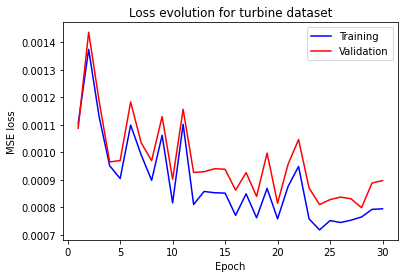

In [15]:
real, pred = run_and_plot_for_dataset([[4, 5, 1], 30, 0.01, 0.9, "tanh", 0.2], turbine, 0.85, "turbine")

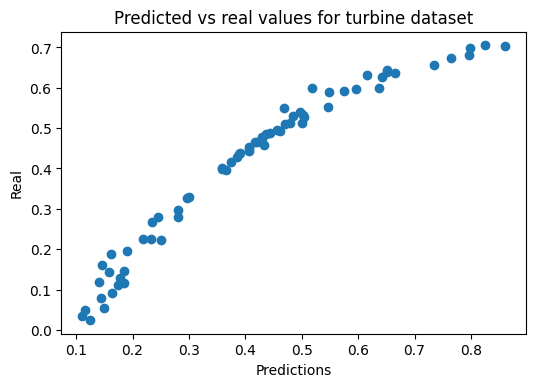

In [367]:
scatter_for_network(real, pred, "turbine")

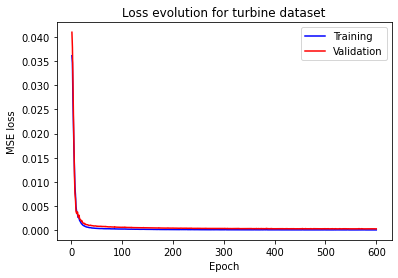

In [82]:
real, pred = run_and_plot_for_dataset([[4, 5, 8, 1], 600, 0.01, 0.2, "relu", 0.2], turbine, 0.85, "turbine")

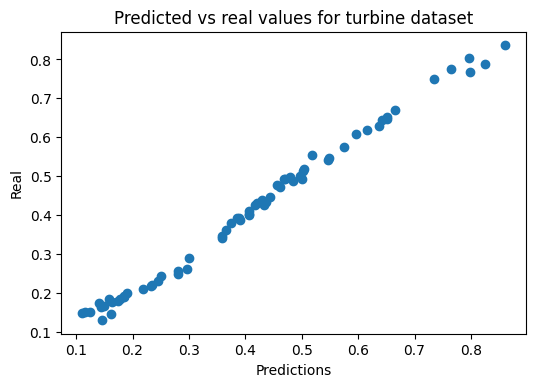

In [379]:
scatter_for_network(real, pred, "turbine")

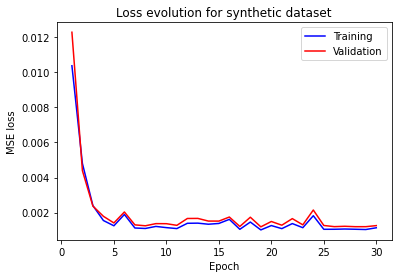

In [80]:
real, pred = run_and_plot_for_dataset([[9, 7, 6, 1], 30, 0.01, 0.9, "relu", 0.2], synthetic, 0.8, "synthetic")

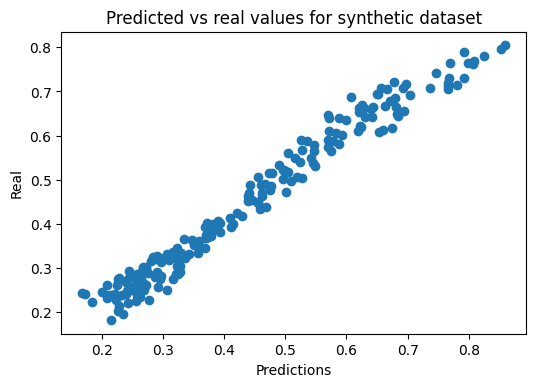

In [433]:
scatter_for_network(real, pred, "synthetic")

In [61]:
import importlib
importlib.reload(MyNeuralNetwork_New)

<module 'MyNeuralNetwork_New' from '/home/mrs/URV/NEC/HW1/MyNeuralNetwork_New.py'>

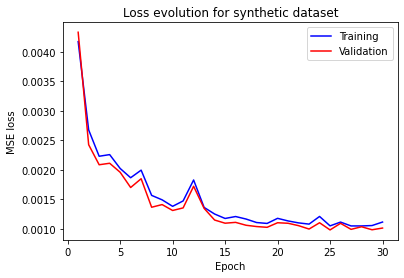

In [56]:
real, pred = run_and_plot_for_dataset([[9, 1], 30, 0.01, 0.9, "tanh", 0.2], synthetic, 0.8, "synthetic")

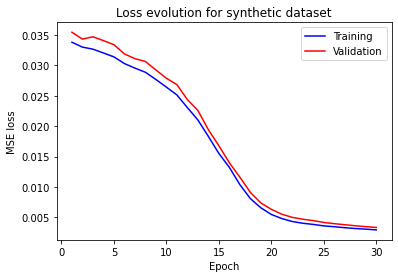

In [62]:
real, pred = run_and_plot_for_dataset([[9, 8, 6, 1], 30, 0.01, 0.9, "sigmoid", 0.2], synthetic, 0.8, "synthetic")

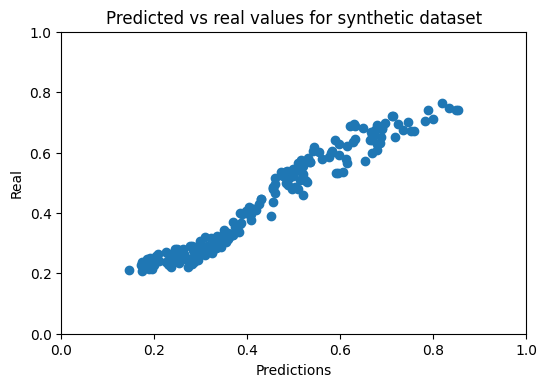

In [574]:
scatter_for_network(real, pred, "synthetic")

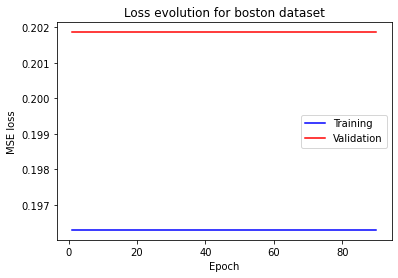

In [63]:
real, pred = run_and_plot_for_dataset([[13, 8, 6, 1], 90, 0.001, 0.7, "relu", 0.2], boston, 0.8, "boston")

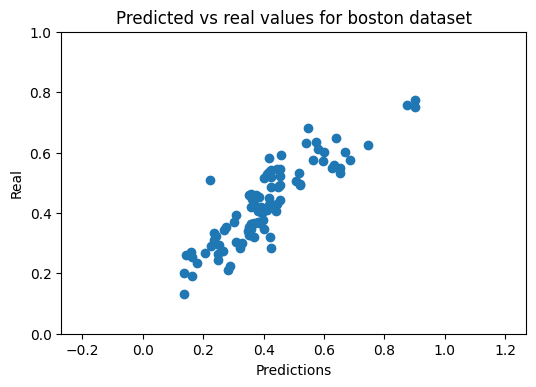

In [549]:
scatter_for_network(real, pred, "boston")

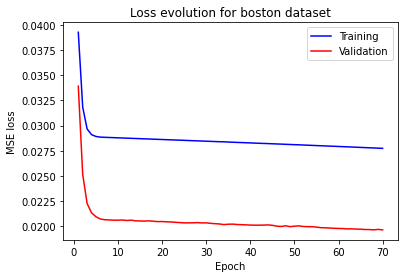

In [101]:
real, pred = run_and_plot_for_dataset([[13, 8, 6, 1], 70, 0.001, 0.9, "sigmoid", 0.2], boston, 0.8, "boston")

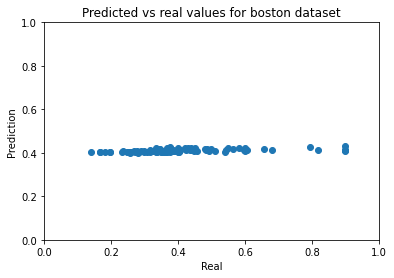

In [102]:
scatter_for_network(pred, real, "boston")

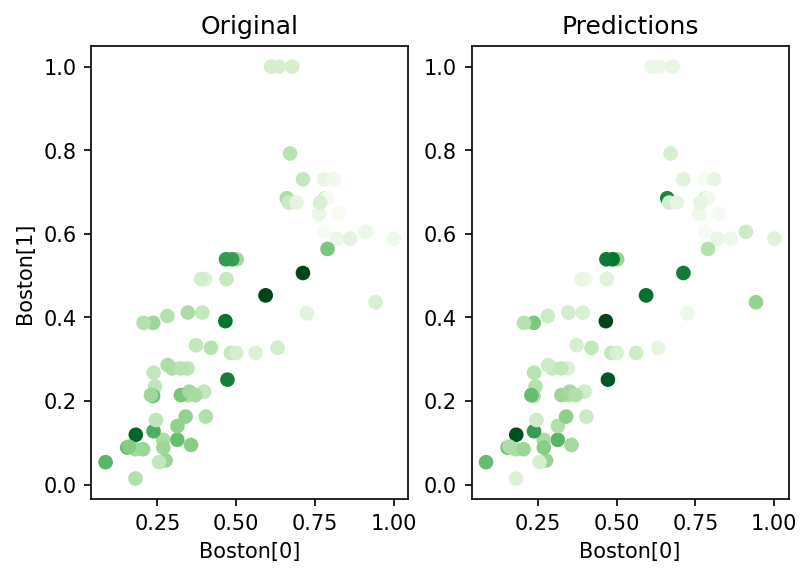

In [264]:
# A nice plot with colors representing predictions and needed value
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

n_epochs = 100
data = boston
network = MyNeuralNetwork_New.MyNeuralNetwork([13, 8, 7, 1], n_epochs, 0.01, 0.9, "tanh", 0.2)
# Train on part of data and scatter predictions
split_index = int(0.85 * data.shape[0])
network.fit(data[:split_index, :-1], data[:split_index, -1], batch_size=10)
predictions = network.predict(data[split_index:, :-1])

plt.subplot(1, 2, 1)
plt.scatter(data[split_index:, 0], data[split_index:, 4], c=data[split_index:, -1], marker='o', cmap='Greens')
plt.xlabel("Boston[0]")
plt.ylabel("Boston[1]")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.xlabel("Boston[0]")
plt.title("Predictions")
plt.scatter(data[split_index:, 0], data[split_index:, 4], c=predictions, marker='o', cmap='Greens')



# Part 3.2

### I was playing much with parameters here and rerunning stuff for tables generation, so it's a mess here now. I was replacing function inputs for different datasets

In [69]:
measure_model_error_multiple_times(lambda *args: run_pytorch_network([[13, 8, 6, 1], 'tanh'], *args), boston.copy(), num_runs=1)

Model MSE on test: 0.005592381116002798


(16.55528098344803, 0.005592381)

In [91]:
measure_model_error_multiple_times(lambda *args: run_my_neural_network([[9, 8, 6, 1], 30, 0.01, 0.9, 'tanh', 0.01], *args), synthetic.copy(), num_runs=1)


Model MSE on test: 0.001272045271429667


(7.784317795764312, 0.001272045271429667)

In [73]:
measure_model_error_multiple_times(run_linear_regression, synthetic, num_runs=1)

Model MSE on test: 0.001004862948320806


(38.720935583114624, 0.001004863)

In [26]:
# Generating stcetter plots for each of networks
turbine_train = turbine[:int(0.85 * turbine.shape[0])]
turbine_test = turbine[int(0.85 * turbine.shape[0]):]

synthetic_train = synthetic[:int(0.8 * synthetic.shape[0])]
synthetic_test = synthetic[int(0.8 * synthetic.shape[0]):]

boston_train = boston[:int(0.8 * boston.shape[0])]
boston_test = boston[int(0.8 * boston.shape[0]):]


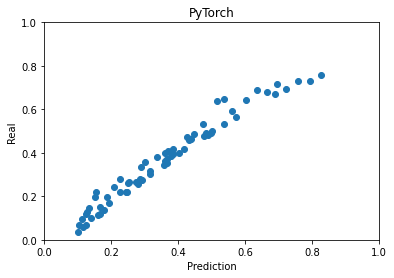

In [24]:
predictions = run_pytorch_network([[4, 5, 8, 10, 6, 1], 'tanh'], turbine_train, turbine_test[:, :-1])
scatter_for_network(turbine_test[:, -1], predictions, "PyTorch")

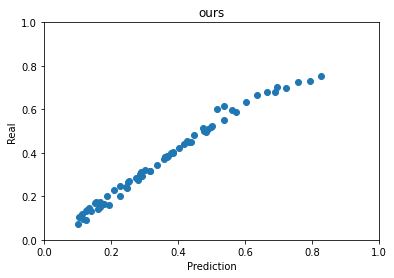

In [27]:
predictions = run_my_neural_network([[4, 5, 8, 10, 6, 1], 60, 0.001, 0.9, 'tanh', 0.01], turbine_train, turbine_test[:, :-1])
scatter_for_network(turbine_test[:, -1], predictions, "ours")

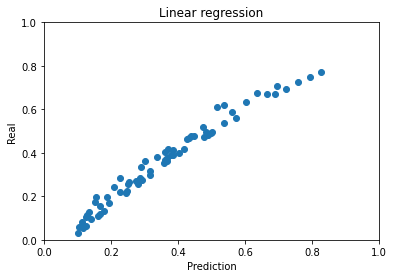

In [28]:
predictions = run_linear_regression(turbine_train, turbine_test[:, :-1])
scatter_for_network(turbine_test[:, -1], predictions, "Linear regression")

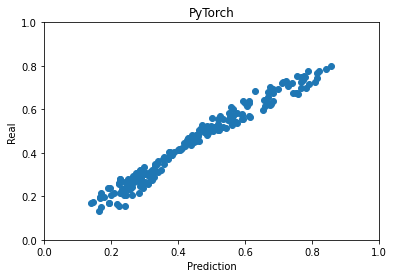

In [32]:
predictions = run_pytorch_network([[9, 8, 6, 1], 'tanh'], synthetic_train, synthetic_test[:, :-1])
scatter_for_network(synthetic_test[:, -1], predictions, "PyTorch")

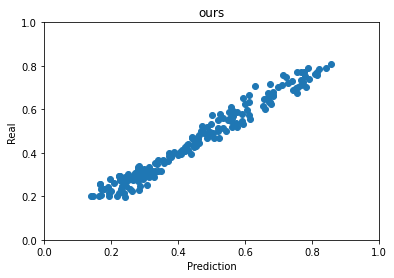

In [33]:

predictions = run_my_neural_network([[9, 8, 6, 1], 30, 0.01, 0.9, 'tanh', 0.01], synthetic_train, synthetic_test[:, :-1])
scatter_for_network(synthetic_test[:, -1], predictions, "ours")

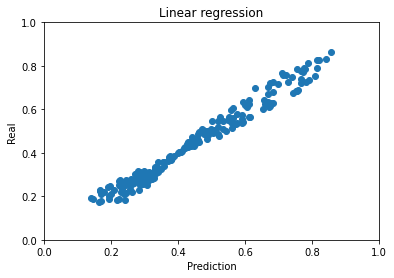

In [34]:

predictions = run_linear_regression(synthetic_train, synthetic_test[:, :-1])
scatter_for_network(synthetic_test[:, -1], predictions, "Linear regression")

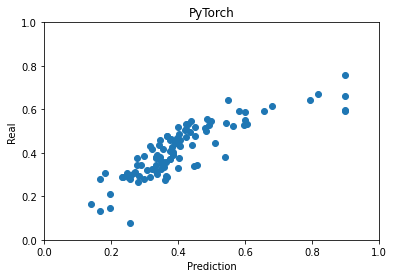

In [35]:
predictions = run_pytorch_network([[13, 8, 6, 1], 'tanh'], boston_train,
                                    boston_test[:, :-1])
scatter_for_network(boston_test[:, -1], predictions, "PyTorch")

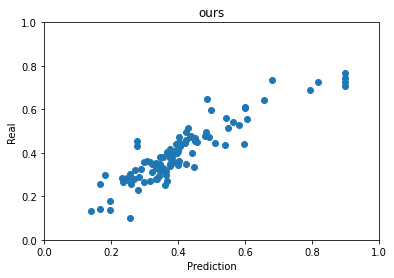

In [36]:

predictions = run_my_neural_network([[13, 8, 6, 1], 150, 0.001, 0.9, 'tanh', 0.01], boston_train,
                                    boston_test[:, :-1])
scatter_for_network(boston_test[:, -1], predictions, "ours")

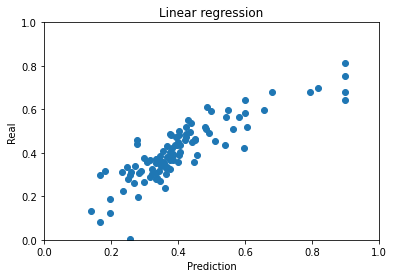

In [37]:

predictions = run_linear_regression(boston_train,
                                    boston_test[:, :-1])
scatter_for_network(boston_test[:, -1], predictions, "Linear regression")